In [123]:
import numpy as np
from numpy import random
import cv2

from skimage.segmentation import slic, mark_boundaries
from skimage import io
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.color
from skimage.future import graph
from skimage import feature, transform
from skimage import measure
from skimage import exposure
from skimage.feature import local_binary_pattern
from skimage.measure import regionprops
from skimage.feature import greycomatrix, greycoprops

from scipy.spatial.distance import pdist

import networkx as nx
import timeit

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style="ticks", color_codes=True)

%matplotlib inline

In [2]:
font_dict = {'family': 'sans',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

In [3]:
def show_image(img):
    f = plt.figure(figsize=(8, 12))
    plt.imshow(img)
    plt.axis('off');

In [4]:
def masking_image(img, mask):
    dst = img.copy()
    dst[:,:,1] = dst[:,:,1] * mask
    return dst

In [5]:
def weight_boundary(graph, src, dst, n):
    default = {'weight': 0.0, 'count': 0}

    count_src = graph[src].get(n, default)['count']
    count_dst = graph[dst].get(n, default)['count']

    weight_src = graph[src].get(n, default)['weight']
    weight_dst = graph[dst].get(n, default)['weight']

    count = count_src + count_dst
    return {
        'count': count,
        'weight': (count_src * weight_src + count_dst * weight_dst)/count
    }

def merge_boundary(graph, src, dst):
    pass

In [6]:
def floor_label(labels):
    """takes the lable value from the central lower part of image"""
    h, w = labels.shape
    potential_floor = labels[int(h/2):, int(w/4):int(w*3/4)]
    
#     fig, ax = plt.subplots(1,2)
#     ax[0].imshow(labels)
#     ax[1].imshow(potential_floor)
    
    # choose the biggest segments 
    unique, counts = np.unique(potential_floor, return_counts=True)
    res_dict = dict(zip(unique, counts))
    main_label = sorted(res_dict.items(), key=lambda kv: kv[1], reverse=True)[0][0]
#     return labels[int(h*0.8), int(w*0.5)]
    return main_label

In [7]:
def weight_histogram(g_edg, percent_thresh = 0.80):
    """plot histogram of RAG edges weights and return threshold for a given percentile"""
    from scipy.stats import percentileofscore
    w_list = list(g_edg.edges(data='weight'))
    weights = np.asarray([w[2] for w in w_list])
    percentile = np.quantile(weights, percent_thresh)
    return percentile

### Loading image

/home/dzyga/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/dzyga/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/dzyga/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/dzyga/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will

Image shape resized to  (480, 480, 3)


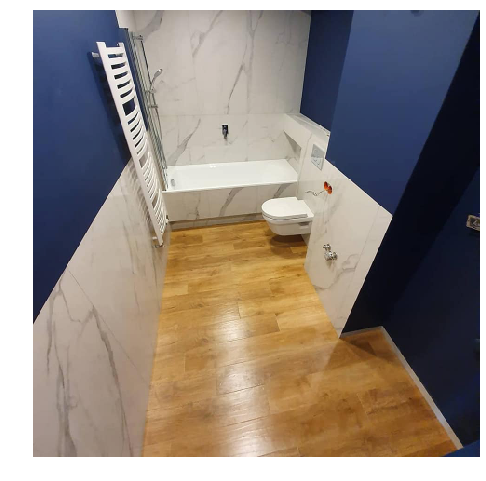

In [8]:
evaluation = True # False #False #True

# file = '4.jpg'
# file = 'img0.png'
# file = './Fwd_ floor segmentation proposal/image1.jpeg'
# fname = '50917092_2014590568590932_4249364050510610432_o.jpg' # chair in the corner
# fname = '82053699_2482903105153946_2058936514871558144_n.jpg' # floor with deep contrast
# fname = '70120232_2473173446084559_2338160950193946624_n.jpg' # 
fname = '80022923_3021808931181382_173503145316450304_n.jpg'
# fname = '46485749_1919646444752012_4789851260549332992_o.jpg' # test 
# fname = 'Walczak_9.jpg'
file = './dataset/' + fname 

# from the net
# file = './1f8c855ec8ecc46123fc2cfa41hj--walls-panel-under-art-rust-texture-rusty-wall.jpg'

img = io.imread(file)
img_original = img.copy()

if evaluation:
    file_gt = './dataset/ground_truth/' + fname
    img_gt = io.imread(file_gt)
    img_gt = img_gt[:,:,0]
    img_gt[img_gt <= 125] = 0
    img_gt[img_gt > 125] = 1
else:
    img_gt = np.zeros_like(img)
    
    
# read NN mask 
# img = io.imread(file)

imh, imw, imc = img.shape
imh_orig = imh
imw_orig = imw
if imh > 600 and imh < 1000: 
    img = transform.resize(img, (int(imh/2), int(imw/2)))
    mask_gt = transform.resize(img_gt, (int(imh/2), int(imw/2)))
    print('Image shape resized to ', img.shape)
    imh, imw, imc = img.shape
elif imh > 1000:
    img = transform.resize(img, (int(imh/4), int(imw/4)))
    mask_gt = transform.resize(img_gt, (int(imh/4), int(imw/4)))
    print('Image shape resized to ', img.shape)
    imh, imw, imc = img.shape
else:
    mask_gt = img_gt
    


hsvimg = skimage.color.rgb2hsv(img)
himg = hsvimg[:,:,0]
simg = hsvimg[:,:,1]
vimg = hsvimg[:,:,2]
gimg = skimage.color.rgb2gray(img)

show_image(img)

In [9]:
# Histogram equalization
img_adapteq = exposure.equalize_adapthist(hsvimg, clip_limit=0.3)

/home/dzyga/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


### SLIC Superpixels

Number of unique labels is  257


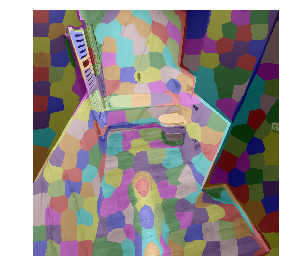

In [10]:
num_segmnts = 300
img_labels_slic = slic(img, n_segments = num_segmnts, sigma = 5, compactness = 7)

io.imshow(skimage.color.label2rgb(img_labels_slic, img))
plt.axis('off'); 
print('Number of unique labels is ', len(np.unique(img_labels_slic)))

### RAG and clustering

In [11]:
METHOD = 'var'
radius = 5
n_points = 8 * radius
lbp2 = local_binary_pattern(simg, n_points, radius, METHOD)
lbp3 = local_binary_pattern(vimg, n_points, radius, METHOD)
lbp = lbp3+lbp2
# Handling missing values
lbp[np.isnan(lbp)] = np.nanmean(lbp)
# Smooth edges of image
x = 5
lbp[:, :x] = np.median(lbp)
lbp[:x, :] = np.median(lbp)
lbp[-x:, :] = np.median(lbp)
lbp[:, -x:] = np.median(lbp)

# plt.imshow(lbp), plt.title('Edge map by LBP'), plt.axis('off');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


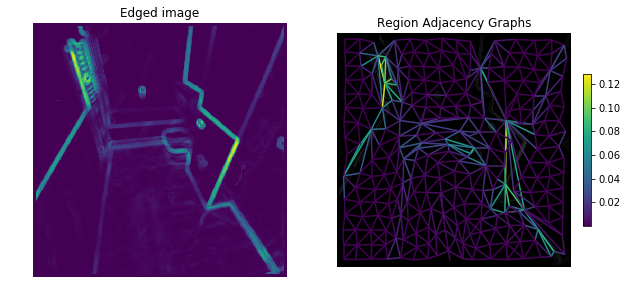

In [12]:
# Edge map
# edges = filters.sobel(simg)
edges = lbp
edges_rgb = skimage.color.gray2rgb(edges)

# Graph 
g_edg = graph.rag_boundary(img_labels_slic, edges, connectivity=2)

fig, axes = plt.subplots(1,2, figsize=(10, 8), sharey=True)
axes[0].set_title('Edged image')
axes[0].imshow(edges)
axes[0].axis('off')
axes[1].set_title('Region Adjacency Graphs')
lc = graph.show_rag(img_labels_slic, g_edg, edges_rgb, img_cmap=None, edge_cmap='viridis', ax=axes[1])
axes[1].axis('off')
fig.colorbar(lc, fraction=0.03);


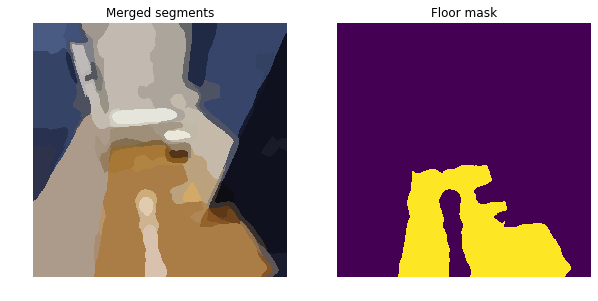

In [13]:
# hierarchical merging
w_list = list(g_edg.edges(data='weight'))
weights = np.asarray([w[2] for w in w_list])
Q = np.quantile(weights, 0.60)
img_labels_merged = graph.merge_hierarchical(img_labels_slic, g_edg, Q, rag_copy=True,
                                   in_place_merge=True,
                                   merge_func=merge_boundary,
                                   weight_func=weight_boundary)

# show_image(color.label2rgb(img_labels_merged, img, kind='avg'))

# floor mask from merged labels
target_label = floor_label(img_labels_merged)
mask_merged = np.zeros(img_labels_merged.shape, dtype=np.float32)
mask_merged[img_labels_merged == target_label] = 1

fig, axes = plt.subplots(1,2, figsize=(10, 8), sharey=True)
axes[0].set_title('Merged segments')
axes[0].imshow(skimage.color.label2rgb(img_labels_merged, img, kind='avg'))
axes[0].axis('off')
axes[1].set_title('Floor mask')
axes[1].imshow(mask_merged)
axes[1].axis('off');

## Clustering by features

In [14]:
# Change label image here 
img_labels = img_labels_slic 
segments = regionprops(img_labels, simg)

### GLCM feature  

In [15]:
def get_glcm_features(patch):
    """fet glcm feature for the input patch
    of an image """
    patch = cv2.convertScaleAbs(patch)
    # list of GLCM feature 
    features = [
     'dissimilarity', 
     'homogeneity', 
     'energy',
#      'correlation',
     'contrast',
     'ASM']

    N = len(features)
    feature_vec = np.zeros(N)
    glcm_img = greycomatrix(patch, [5], [0, np.pi/4, np.pi/2, 3*np.pi/4],
                            levels=256, normed=True)
    for j,f in enumerate(features):
        feature_vec[j] = greycoprops(glcm_img, f)[0,0]
    return feature_vec.reshape(1,-1)
# get_glcm_features(patch)

In [16]:
# GLCM feature 

# for whole picture - to normalize 
feature_vec_image = get_glcm_features(simg)

# for segments in image 
N = feature_vec_image.shape[1]
M = len(segments) 
    
feature_matr = np.zeros([M,N])
for i,props in enumerate(segments):
    feature_matr[i, :] = get_glcm_features(props.intensity_image.squeeze())

### LBP features 

In [17]:
# # LBP

# Nlbp = len(lbp_methods)
# # Mlbp = len(segments)
 
# def get_lbp_features(patch):
#     patch = cv2.convertScaleAbs(patch)
#     radius = 3
#     n_points = 8 * radius
#     lbp_methods = ['uniform',
#                'default', 
#                'ror',
#                'nri_uniform',
#                'var']
#     Nbins = 8
#     for method in lbp_methods:
#         lbp_patch = np.zeros([Mlbp, Nbins])
#         lbp  = local_binary_pattern(patch, n_points, radius, method)
# #         feature_hist, _ = np.histogram(lbp, bins = Nbins)
# #         lbp_matr[i, :] = feature_hist
# #     feature_matr = np.hstack((feature_matr,lbp_matr))

In [18]:
# lbp_matr = np.zeros([Mlbp, Nbins])
# for i, props in enumerate(segments):
#     patch = cv2.convertScaleAbs(props.intensity_image.squeeze())
#     lbp  = local_binary_pattern(patch, n_points, radius, METHOD)
#     feature_hist, _ = np.histogram(lbp, bins = Nbins)
#     lbp_matr[i, :] = feature_hist
# feature_matr = np.hstack((feature_matr,lbp_matr))

### Clustering

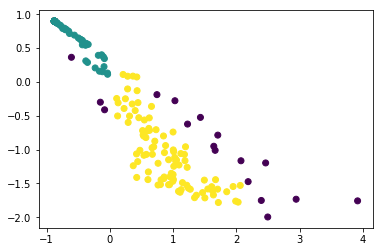

In [19]:
from sklearn.preprocessing import scale
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
# from sklearn.decomposition import PCA

# !!!!!!!!!!!!!!!!!!! Handling NaN 
feature_matr[np.isnan(feature_matr)] = 0
data = scale(feature_matr) # features for slic or merged segments 
n_samples, n_features = data.shape

# # K-Means
# n_clusters = 5
# kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10).fit(data)
# y_pred = kmeans.predict(data)
# plt.scatter(data[:, 0], data[:, 2], c=y_pred);

# DBSCAN
db = DBSCAN(eps=0.4, min_samples=10).fit(data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
y_pred = db.labels_
plt.scatter(data[:, 0], data[:, 2], c=y_pred);

In [20]:
# group im clusters by predicted labels by filling segments (x,y) wiht corresponding label 
img_labels_pred = np.zeros_like(img_labels) 
for i, props in enumerate(segments):
    for r, c in props.coords:
        img_labels_pred[r,c] = y_pred[i]
# show_image(img_labels_pred)
type(img_labels_pred[0,0])

numpy.int64

In [21]:
# grab the floor label in predicted mask
target_label = floor_label(img_labels_pred)
mask_pred = np.zeros(img_labels_pred.shape, dtype=np.float32)
mask_pred[img_labels_pred == target_label] = 1

# # show and compare two masks
# fig, axes = plt.subplots(1,2, figsize=(10, 8), sharey=True)
# axes[0].set_title('Mask from merging')
# axes[0].imshow(mask_merged)
# axes[0].axis('off')
# axes[1].set_title('Mask from prediction')
# axes[1].imshow(mask_pred)
# axes[1].axis('off');

## Post processing

In [79]:
def labels_from_mask(segmentation_mask):
    contours, _ = cv2.findContours(cv2.convertScaleAbs(segmentation_mask),
                                        cv2.RETR_CCOMP, #cv2.RETR_TREE, # 
                                        cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key = cv2.contourArea,reverse=True)
    map_labels = np.zeros_like(segmentation_mask)
    for cnt in contours:
        c = np.random.randint(1, 254)
        cv2.fillPoly(map_labels, [cnt], color = c) 
    # map_labels = map_labels.astype(np.int)
    return map_labels

In [80]:
def find_biggest_segment(image, mask):
    map_orig = labels_from_mask(mask)
    # invered mask
    map_inv = labels_from_mask(np.max(mask)-mask)
    # both togeather
    map_sum = map_orig+map_inv
    map_sum = cv2.convertScaleAbs(map_sum)

    # create new labeled image 
    segments_postproc = regionprops(map_sum, image)

    # sort segments from low to high area 
    return  sorted(segments_postproc, key=lambda s: s.area)

In [81]:
mask = mask_merged
contours, hierarchy = cv2.findContours(cv2.convertScaleAbs(mask),
                                       cv2.RETR_CCOMP, #cv2.RETR_TREE, # 
                                       cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key = cv2.contourArea,reverse=True)
map_orig = np.zeros_like(simg)
for i, cnt in enumerate(contours):
    c = np.random.randint(255)
    cv2.fillPoly(map_orig, [cnt], color = c) 
# plt.imshow(map_orig);
map_orig = map_orig.astype(np.int)

contours, hierarchy = cv2.findContours(cv2.convertScaleAbs(np.max(mask)-mask),
                                       cv2.RETR_CCOMP, #cv2.RETR_TREE, # 
                                       cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key = cv2.contourArea, reverse=True)
map_inv = np.zeros_like(simg)
for i, cnt in enumerate(contours):
    c = np.random.randint(255)
    cv2.fillPoly(map_inv, [cnt], color = c) 
# plt.imshow(map_inv);
map_inv = map_inv.astype(np.int)

map_sum = map_orig+map_inv
map_sum1 = cv2.convertScaleAbs(map_sum)

# # segments from labels
# segments_postproc1 = regionprops(map_sum1, simg)
# segments_postproc1 = sorted(segments_postproc, key=lambda s: s.area)

# temp_mask = np.zeros(mask.shape)
# for r, c in segments_postproc[-1].coords:
#     temp_mask[r,c] = 1

# check = (temp_mask*mask).max()

# if check == 1: 
#     mask_floor_org = temp_mask
#     mask_nonfloor_org = np.zeros(mask.shape)
#     for r, c in segments_postproc[-2].coords:
#         mask_nonfloor_org[r,c] = 5

# else:
#     mask_floor_org = temp_mask*mask
    
# show_image(mask_nonfloor_org)

### Give unique labels to areas under the contours

In [82]:
# choose a mask to post process 
mask = mask_pred

In [99]:
# Original image 
contours, hierarchy = cv2.findContours(cv2.convertScaleAbs(mask),
                                       cv2.RETR_CCOMP, #cv2.RETR_TREE, # 
                                       cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key = cv2.contourArea,reverse=True)
map_orig = np.zeros_like(simg)
for i, cnt in enumerate(contours):
    c = np.random.randint(2,254)
    cv2.fillPoly(map_orig, [cnt], color = c) 
# plt.imshow(map_orig);
map_orig = map_orig.astype(np.int)


In [100]:
# Inverted image 
contours, hierarchy = cv2.findContours(cv2.convertScaleAbs(np.max(mask)-mask),
                                       cv2.RETR_CCOMP, #cv2.RETR_TREE, # 
                                       cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key = cv2.contourArea, reverse=True)
map_inv = np.zeros_like(simg)
for i, cnt in enumerate(contours):
    c = np.random.randint(2,254) # exclude 0 and 255 
    cv2.fillPoly(map_inv, [cnt], color = c) 
# plt.imshow(map_inv);
map_inv = map_inv.astype(np.int)

In [101]:
# Sum of two map
map_sum = map_orig+map_inv
map_sum2 = cv2.convertScaleAbs(map_sum)

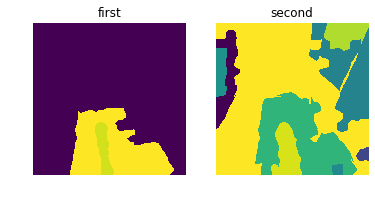

In [102]:
_,ax = plt.subplots(1,2, )
ax[0].imshow(map_sum1)
ax[0].set_title('first')
ax[0].axis('off')
ax[1].imshow(map_sum2)
ax[1].set_title('second')
ax[1].axis('off');

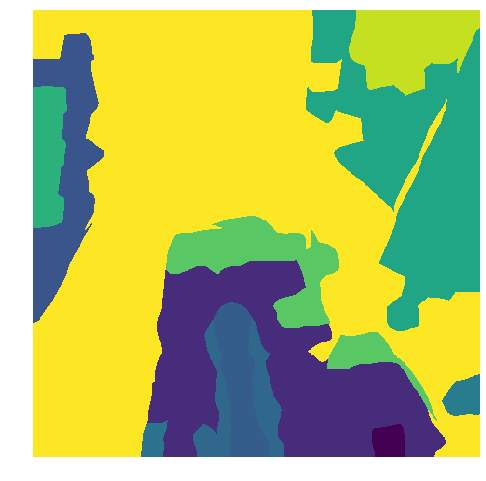

In [103]:
map_sum = map_sum1+map_sum2
show_image(cv2.convertScaleAbs(map_sum))#cv2.convertScaleAbs(mask)

In [104]:
np.unique(map_sum)

array([ 50,  76, 104, 110, 119, 128, 136, 171, 181, 202, 236, 254],
      dtype=uint8)

### Check floor and non floor labels

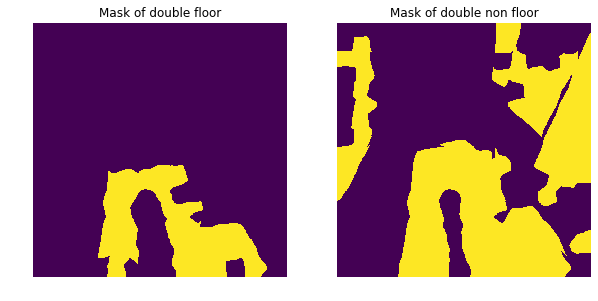

In [105]:
mask_double_floor = cv2.convertScaleAbs(mask_merged*mask_pred)
mask_double_nonfloor = mask_merged+mask_pred
mask_double_nonfloor[mask_double_nonfloor>0]=1
mask_double_nonfloor = cv2.convertScaleAbs(mask_double_nonfloor) # invert? 

# show and compare two masks
fig, axes = plt.subplots(1,2, figsize=(10, 8), sharey=True)
axes[0].set_title('Mask of double floor')
axes[0].imshow(mask_double_floor)
axes[0].axis('off')
axes[1].set_title('Mask of double non floor')
axes[1].imshow(mask_double_nonfloor)
axes[1].axis('off');

In [106]:
# check floor label
double_floor = find_biggest_segment(simg, mask_double_floor)[-2:]
double_nonfloor = find_biggest_segment(simg, mask_double_nonfloor)[-2:]

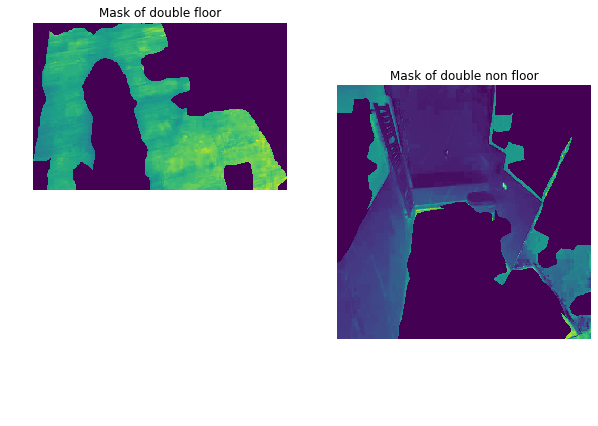

In [107]:
# floor 
temp_mask = np.zeros(mask.shape)

for r, c in double_floor[0].coords:
    temp_mask[r,c] = 1
if (temp_mask*mask_double_floor).max() == 1: 
#     double_floor[0].label = 1 # this is definitely floor 
#     double_floor[1].label = 0 # we don't know really 
    double_floor_segm = double_floor[0]
else:
#     double_floor[0].label = 0 # vise versa
#     double_floor[1].label = 1
    double_floor_segm = double_floor[1]
    
# non floor 
temp_mask = np.zeros(mask.shape)
for r, c in double_nonfloor[0].coords:
    temp_mask[r,c] = 1
if (temp_mask*mask_double_nonfloor).max() == 1: 
#     double_nonfloor[0].label = 0 # this is definitely a non floor 
#     double_nonfloor[1].label = 1 # we don't know really 
    double_nonfloor_segm = double_nonfloor[1]
    
else:
#     double_nonfloor[0].label = 1 # vise versa
#     double_nonfloor[1].label = 0   
    double_nonfloor_segm = double_nonfloor[0]
    
    
# check results
_, axes = plt.subplots(1,2, figsize=(10, 8), sharey=True)
axes[0].set_title('Mask of double floor')
axes[0].imshow(double_floor_segm.intensity_image)
axes[0].axis('off')
axes[1].set_title('Mask of double non floor')
axes[1].imshow(double_nonfloor_segm.intensity_image)
axes[1].axis('off');

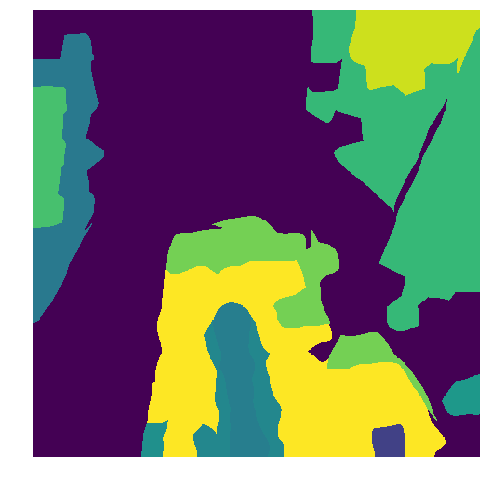

In [108]:
# fill segment map with 0 and 1 corresponded to non floor and floor 
# temp_mask = np.ones(map_sum.shape) * 127 
mask_ref_floor = np.zeros(map_sum.shape)
mask_ref_nonfloor = np.zeros(map_sum.shape)

for r, c in double_floor_segm.coords:
    map_sum[r,c] = 255
    mask_ref_floor[r,c] = 255
for r, c in double_nonfloor_segm.coords:
    map_sum[r,c] = 1 ### Skimage ignores label = 0 so we use 1 !!!!!!!!!!!!
    mask_ref_nonfloor[r,c] = 255

show_image(map_sum)

In [36]:
# it was the wrong way

# double_floor = find_biggest_segment(simg, mask_double_floor)[-2:]
# if double_floor[0].label == 1: 
#     mask_double_floor_segm = double_floor[0]
# else:
#     mask_double_floor_segm = double_floor[1]
    
    
# double_nonfloor = find_biggest_segment(simg, mask_double_nonfloor)[-2:]
# if double_nonfloor[0].label == 0: 
#     mask_double_nonfloor_segm = double_nonfloor[0]
# else:
#     mask_double_nonfloor_segm = double_nonfloor[1]
    
# # # ---- floor ----    
# # x1, y1, x2, y2 = double_floor[0].bbox
# # M0 = mask_double_floor[x1:x2, y1:y2].mean()
# # x1, y1, x2, y2 = double_floor[1].bbox
# # M1 = mask_double_floor[x1:x2, y1:y2].mean()
# # if M0 > M1:
# #     mask_double_floor_segm = double_floor[0]
# # else: 
# #     mask_double_floor_segm = double_floor[1]    
    
# # # ---- non floor ----    
# # x1, y1, x2, y2 = double_nonfloor[0].bbox
# # M0 = mask_double_nonfloor[x1:x2, y1:y2].mean()
# # x1, y1, x2, y2 = double_nonfloor[1].bbox
# # M1 = mask_double_nonfloor[x1:x2, y1:y2].mean()
# # if M0 > M1:
# #     mask_double_nonfloor_segm = double_nonfloor[0]
# # else: 
# #     mask_double_nonfloor_segm = double_nonfloor[1] 
  

# _, axes = plt.subplots(1,2, figsize=(10, 8), sharey=True)
# axes[0].set_title('Mask of double floor')
# axes[0].imshow(mask_double_floor_segm.intensity_image)
# axes[0].axis('off')
# axes[1].set_title('Mask of double non floor')
# axes[1].imshow(mask_double_nonfloor_segm.intensity_image)
# axes[1].axis('off');

In [37]:
# # show_image(double_floor[0].filled_image)

# x1, y1, x2, y2 = double_floor[0].bbox
# M0 = mask_double_floor[x1:x2, y1:y2].mean()
# x1, y1, x2, y2 = double_floor[1].bbox
# M1 = mask_double_floor[x1:x2, y1:y2].mean()
# if M0 > M1:
#     mask_double_nonfloor_segm = double_nonfloor[0]
# else: 
#     mask_double_nonfloor_segm = double_nonfloor[1]

In [38]:
# contours, hierarchy = cv2.findContours(cv2.convertScaleAbs(mask),
#                                        cv2.RETR_CCOMP, #cv2.RETR_TREE, # 
#                                        cv2.CHAIN_APPROX_NONE)
# contours = sorted(contours, key = cv2.contourArea,reverse=True)
# map_orig = np.zeros_like(simg)
# for i, cnt in enumerate(contours):
#     c = np.random.randint(255)
#     cv2.fillPoly(map_orig, [cnt], color = c) 
# # plt.imshow(map_orig);
# map_orig = map_orig.astype(np.int)

# contours, hierarchy = cv2.findContours(cv2.convertScaleAbs(np.max(mask)-mask),
#                                        cv2.RETR_CCOMP, #cv2.RETR_TREE, # 
#                                        cv2.CHAIN_APPROX_NONE)
# contours = sorted(contours, key = cv2.contourArea, reverse=True)
# map_inv = np.zeros_like(simg)
# for i, cnt in enumerate(contours):
#     c = np.random.randint(255)
#     cv2.fillPoly(map_inv, [cnt], color = c) 
# # plt.imshow(map_inv);
# map_inv = map_inv.astype(np.int)

# map_sum = map_orig+map_inv
# map_sum1 = cv2.convertScaleAbs(map_sum)

### Tecture features for all segments 

In [110]:
segments_postproc = regionprops(map_sum, simg)
# sort segments from low to high area 
segments_postproc = sorted(segments_postproc, key=lambda s: s.area)

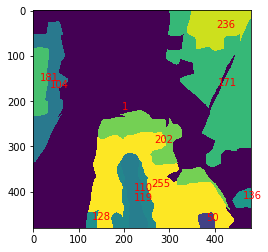

In [112]:
plt.imshow(map_sum)
for props in segments_postproc:
    cx, cy = props.centroid  # centroid coordinates
#     msize = props.area
    plt.text(int(cy), int(cx), props.label, fontsize=10, color='red')#

In [191]:
np.unique(map_sum)

array([  1,  50, 104, 110, 119, 128, 136, 171, 181, 202, 236, 255],
      dtype=uint8)

0.9704301075268735
[[0.0687097  0.96564515 0.66228414 0.0687097  0.43862028]]
[[0.02044737 0.98977632 0.86274983 0.02044737 0.74433727]]


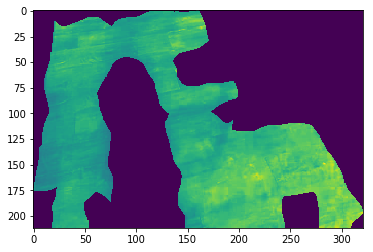

In [192]:
for x in segments_postproc:
    if x.label == 255:
        plt.imshow(x.intensity_image.squeeze())
        print(x.intensity_image.squeeze().max())
        g = get_glcm_features(x.intensity_image.squeeze()) # current feature vector
        print(g)
        z = pdist(np.concatenate((g,features_floor),axis=0), 'euclidean')
        y = pdist(np.concatenate((g,features_nonfloor),axis=0), 'euclidean')
        print(features_floor)
# np.sqrt(g[0]-features_floor[0])

In [183]:
mask_ref_floor/mask_ref_floor.max()

1.0

8.171828947368423
0.030223684210526316


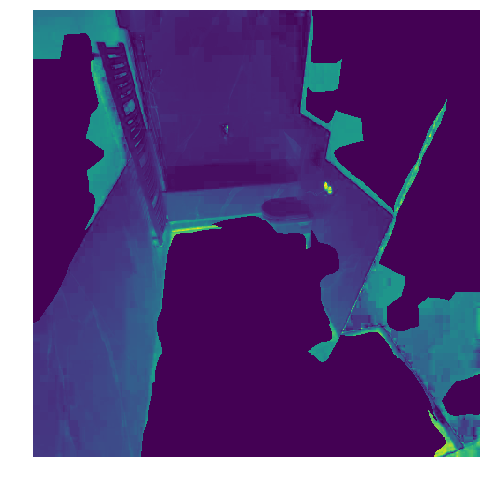

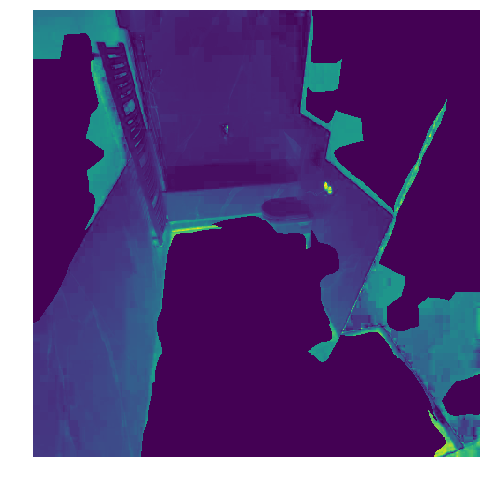

In [188]:
# # check wiht ground truth 
features_floor = get_glcm_features(simg*(mask_ref_floor/mask_ref_floor.max()))
# true non floor? 
features_nonfloor = get_glcm_features(simg*(1-(mask_ref_floor/mask_ref_nonfloor.max())))

# check wiht ground truth 
# features_floor = get_glcm_features(simg*mask_ref_floor)
# # true non floor? 
# features_nonfloor = get_glcm_features(simg*(1-mask_ref_nonfloor))



print(get_glcm_features(simg*mask_ref_nonfloor)[0][0])
print(get_glcm_features(double_nonfloor_segm.intensity_image)[0][0])
show_image(simg*mask_ref_nonfloor)
show_image(double_nonfloor_segm.intensity_image)

In [176]:
double_nonfloor_segm.intensity_image.max()
(simg*mask_ref_nonfloor).max()

243.5607476635549

In [196]:
map_floor = map_sum.copy()
for props in segments_postproc[:-2]:
    g = get_glcm_features(props.intensity_image.squeeze()) # current feature vector

    # calculate euclidean distance to the 'floor' and 'non floor' points
    floor_dist = pdist(np.concatenate((g,features_floor),axis=0), 'euclidean')
    nonfl_dist = pdist(np.concatenate((g,features_nonfloor),axis=0), 'euclidean')
    print(floor_dist)
    print(nonfl_dist)
    # see which point is closer to current segment
    # and relable segment wiht corresponding label
    if floor_dist < nonfl_dist: 
        for r, c in props.coords:
            map_floor[r,c] = 255 
#         props.label = target_floor_label
    else: 
        for r, c in props.coords:
            map_floor[r,c] = 1 

[0.73280318]
[0.54343571]
[0.09138072]
[0.23215304]
[0.61244095]
[0.40915773]
[0.15605547]
[0.20464636]
[0.10797516]
[0.22142142]
[0.27986456]
[0.49146427]
[0.20056172]
[0.40463561]
[0.34407871]
[0.13620547]
[0.04843491]
[0.16833874]
[0.37140591]
[0.15697108]


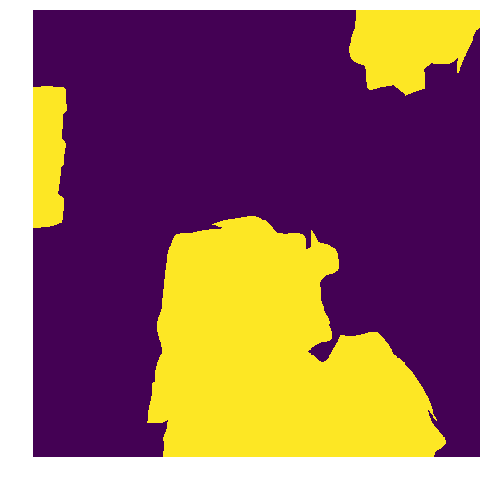

In [197]:
show_image(map_floor)

In [206]:
(cv2.convertScaleAbs(mask)[0,0])

AttributeError: 'numpy.uint8' object has no attribute 'type'

In [46]:
# # sort segments from low to high area 
# segments_postproc = sorted(segments_postproc, key=lambda s: s.area)

# # take two most bigger 
# bigest_area1 = (segments_postproc[-1].label, segments_postproc[-1].centroid[0]) # label, centr
# bigest_area2 = (segments_postproc[-2].label, segments_postproc[-2].centroid[0])

# if bigest_area1[1] > bigest_area2[1]:  
#     # first centroid is lower
#     target_floor_label = bigest_area1[0] 
#     features_floor = get_glcm_features(segments_postproc[-1].intensity_image.squeeze())
    
#     target_nonfloor_label = bigest_area2[0]
#     features_nonfloor = get_glcm_features(segments_postproc[-2].intensity_image.squeeze())    
# else:                            
#     # second centroid is lower
#     target_floor_label = bigest_area2[0] #
#     features_floor = get_glcm_features(segments_postproc[-2].intensity_image.squeeze())
    
#     target_nonfloor_label = bigest_area1[0]
#     features_nonfloor = get_glcm_features(segments_postproc[-1].intensity_image.squeeze())    

# print('Floor label is', target_floor_label)
# print('Non Floor label is', target_nonfloor_label)


In [47]:
# bigest_area1 = (segments_postproc[-1].label, segments_postproc[-1].coords[10,:]) # label, centr
# bigest_area2 = (segments_postproc[-2].label, segments_postproc[-2].coords[10,:])

# x1 = bigest_area1[1][1]
# y1 = bigest_area1[1][0]
# x2 = bigest_area2[1][1]
# y2 = bigest_area2[1][0]

# if check_label == 1: 
#     # this is a floor 
#     target_floor_label = bigest_area1[0]
#     features_floor = get_glcm_features(segments_postproc[-1].intensity_image.squeeze())
#     print('Target label is ', target_floor_label)
# elif check_label == 0:
#     # this is a non floor
#     target_floor_label = bigest_area2[0]
#     features_nonfloor = get_glcm_features(segments_postproc[-2].intensity_image.squeeze())
#     print('Target label is ', target_floor_label)
# else:
#     print('Something wrong')

In [48]:
# # show_image(segments_postproc[-2].image
# temp_mask = np.zeros(mask.shape)
# for r, c in segments_postproc[-1].coords:
#             temp_mask[r,c] = 1

# # show_image(mask)
# # show_image(temp_mask)
# check_label = (temp_mask*mask).max()

In [144]:
if evaluation:
    gt_floor = get_glcm_features(simg*mask_gt)#/feature_vec_image # area from merging
    gt_nonfloor = get_glcm_features(simg*(1-mask_gt))#/feature_vec_image
    
    print('GT-floor: ', gt_floor)
    print('Obtained: ', features_floor)
    
    print('GT-non: ', gt_nonfloor)   
    print('Obtained: ', features_nonfloor)  

GT-floor:  [[0. 1. 1. 0. 1.]]
Obtained:  [[  3.88473684   0.86505765   0.84473109 464.03644737   0.71357061]]
GT-non:  [[0.06724123 0.96637939 0.68438505 0.06724123 0.4683829 ]]
Obtained:  [[8.16013596e+00 6.54494988e-01 3.46045794e-01 7.18847583e+02
  1.19747691e-01]]


NameError: name 'target_nonfloor_label' is not defined

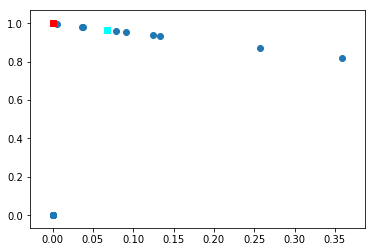

In [50]:
# check from ground truth

if evaluation:
    # check wiht ground truth 
    features_floor = get_glcm_features(simg*mask_gt)#/feature_vec_image # area from merging
    # true non floor? 
    features_nonfloor = get_glcm_features(simg*(1-mask_gt))#/feature_vec_image

    # Vizualization of features 
    feature_matr_postproc = np.zeros([M,N])
    # calculate features for all sesments exept of the biggest two
    for i,props in enumerate(segments_postproc[:-2]): 
        feature_matr_postproc[i, :] = get_glcm_features(props.intensity_image.squeeze())

    x1 = 0
    x2 = 1
    plt.scatter(feature_matr_postproc[:, x1], feature_matr_postproc[:, x2]);
    plt.scatter(features_floor[:,x1],features_floor[:,x2], marker = 's', c = 'red')
    plt.scatter(features_nonfloor[:,x1],features_nonfloor[:,x2], marker = 's', c = 'cyan');
    
    for props in segments_postproc[:-2]:
        g = get_glcm_features(props.intensity_image.squeeze())
        floor_dist = pdist(np.concatenate((g,features_floor),axis=0), 'euclidean')
        nonfl_dist = pdist(np.concatenate((g,features_nonfloor),axis=0), 'euclidean')

        if floor_dist < nonfl_dist: 
            props.label = target_floor_label
        else: 
            props.label = target_nonfloor_label
    
    # relable mask by filling segments (x,y) wiht corresponding label 
    mask_tmp = mask_pred = np.zeros(img_labels.shape, dtype=np.float32) 
    for i, props in enumerate(segments_postproc):
        if props.label == target_floor_label:
            for r, c in props.coords:
                mask_postproc[r,c] = 1
        else:
            for r, c in props.coords:
                mask_postproc[r,c] = 0

    show_image(mask_tmp)


In [ ]:
for props in segments_postproc[:-2]:
    print(props.area)
    g = get_glcm_features(props.intensity_image.squeeze())
    floor_dist = pdist(np.concatenate((g,features_floor),axis=0), 'euclidean')
    nonfl_dist = pdist(np.concatenate((g,features_nonfloor),axis=0), 'euclidean')
    
    print('To floor: ', floor_dist) 
    print('To non floor: ', nonfl_dist) 
    
    if floor_dist < nonfl_dist: 
        props.label = target_floor_label
        print('So segment is a floor')
    else: 
        props.label = target_nonfloor_label
        print('So segment is not a floor') 
    
    print(' ')

# get_glcm_features(segments_postproc[0].intensity_image.squeeze())

In [ ]:
# relable mask by filling segments (x,y) wiht corresponding label 
mask_postproc = np.zeros(img_labels.shape, dtype=np.float32) 
for i, props in enumerate(segments_postproc):
    if props.label == target_floor_label:
        for r, c in props.coords:
            mask_postproc[r,c] = 1
    else:
        for r, c in props.coords:
            mask_postproc[r,c] = 0

show_image(mask_postproc)

In [ ]:
# # Check with ground truth
# features_floor_gt = get_glcm_features(simg*mask_gt)
# features_nonfloor_gt = get_glcm_features(simg*(1-mask_gt))

# img_labels_postproc = np.zeros_like(img_labels) 
# for props in segments_postproc[:-2]:
#     g = get_glcm_features(props.intensity_image.squeeze())
#     floor_dist = pdist(np.concatenate((g,features_floor_gt),axis=0), 'euclidean')
#     nonfl_dist = pdist(np.concatenate((g,features_nonfloor_gt),axis=0), 'euclidean')
    
#     if floor_dist < nonfl_dist: 
#         props.label = target_floor_label
#     else: 
#         props.label = target_nonfloor_label
    
# for i, props in enumerate(segments_postproc):
#     for r, c in props.coords:
#         if props.label == target_floor_label:
#             img_labels_postproc[r,c] = 1
#         else:
#             img_labels_postproc[r,c] = 0
            
# show_image(img_labels_postproc)
# plt.title('From ground truth')

In [ ]:
type(mask_postproc[0,0])
# type(mask_merged[0,0])
type(cv2.convertScaleAbs(mask_postproc)[0,0])
cv2.convertScaleAbs(mask_postproc).max()

In [ ]:
# # Vizualization of bounding boxes
# imgtmp = img.copy()
# # For each contour, find the bounding rectangle and draw it
# for component in zip(contours, hierarchy[0]):
#     currentContour = component[0]
#     currentHierarchy = component[1]
#     x,y,w,h = cv2.boundingRect(currentContour)
#     if currentHierarchy[2] < 0:
#         # these are the innermost child components
#         cv2.rectangle(imgtmp,(x,y),(x+w,y+h),(255,255,0),3)
#     elif currentHierarchy[3] < 0:
#         # these are the outermost parent components
#         cv2.rectangle(imgtmp,(x,y),(x+w,y+h),(0, 255, 0),3)
#     else:
#         cv2.rectangle(imgtmp,(x,y),(x+w,y+h),(0, 0, 255),3)
# show_image(imgtmp)
# plt.title('Areas of interests')

### Interpolation of a mask 

In [ ]:
# # choose mask
# scr = mask_postproc
# mask_interp = np.zeros_like(mask)
# contours, hierarchy = cv2.findContours(cv2.convertScaleAbs(scr),
#                                        cv2.RETR_TREE,
#                                        cv2.CHAIN_APPROX_NONE)   
# # Max contour
# areas = []
# for cnt in contours:
#     areas.append(cv2.contourArea(cnt))    
# true_contour = contours[np.argmax(areas)]
# cv2.drawContours(mask_interp, true_contour, -1, random.rand(3), 3)

# # contour approx
# epsilon = 0.01*cv2.arcLength(true_contour, True)
# approx = cv2.approxPolyDP(true_contour, epsilon, True)

# cv2.fillPoly(mask_interp, [approx], color=(255,255,255))


# fig, ax = plt.subplots(1,3, figsize = (8,12))
# ax[0].imshow(img_gt)
# ax[0].set_title('Ground truth')
# ax[0].axis('off')
# ax[1].imshow(mask)
# ax[1].set_title('Obtained')
# ax[1].axis('off')
# ax[2].imshow(mask_interp)
# ax[2].set_title('Interpolated')
# ax[2].axis('off');

## Evaluation

In [ ]:
# Choose mask 
# mask = mask_merged
# mask = mask_pred
# mask = mask_interp

dst = img.copy()
dst[:,:,1] = dst[:,:,1] * (1-mask)

if dst.shape[0] != imh_orig:
    mask = transform.resize(mask, (imh_orig, imw_orig))
    mask[mask <= 0.5] = 0
    mask[mask > 0.5] = 1
    
iou = np.logical_and(mask, img_gt).sum() / np.logical_or(mask, img_gt).sum()

show_image(dst)
# plt.text(50, 50, "IoU: {:.3f}".format(iou), fontsize=14, color = 'red');
print(iou)

np.sum(mask * img_gt) 
mask.sum()